In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sb
import matplotlib.pyplot as plt
import re
import datetime
from collections import Counter
from matplotlib import ticker
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 14

/home/rzh/BCY/lib/python3.10/site-packages/setuptools_scm/_integration/setuptools.py:30: RuntimeWarning: 
ERROR: setuptools==59.6.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


In [2]:
adata_origin = sc.read_h5ad("adata-preF.h5ad")

In [4]:
adata_origin

AnnData object with n_obs × n_vars = 178891 × 41733
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'major_type', 'molecular_type', 'leiden_harmony', 'major_type_harmony', 'minor_type', 'minor-type', 'gender', 'doublet_score', 'predicted_doublet', 'leiden-harmony-female', 'majorType-Female', 'epi-subtype', 'majorType-fix'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CellphoneDB', 'batch_colors', 'dendrogram_leiden', 'epi-subtype_colors', 'gender_colors', 'hvg', 'leiden', 'leiden-harmony-female_colors', 'leiden_colors', 'leiden_harmony_colors', 'log1p', 'majorType-Female_colors', 'majorType-fix_colors', 'major_type_colors', 'major_type_harmony_colors', 'minor-type_colors', 'minor_type_colors', 'molecular_type_colors', 'neigh

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


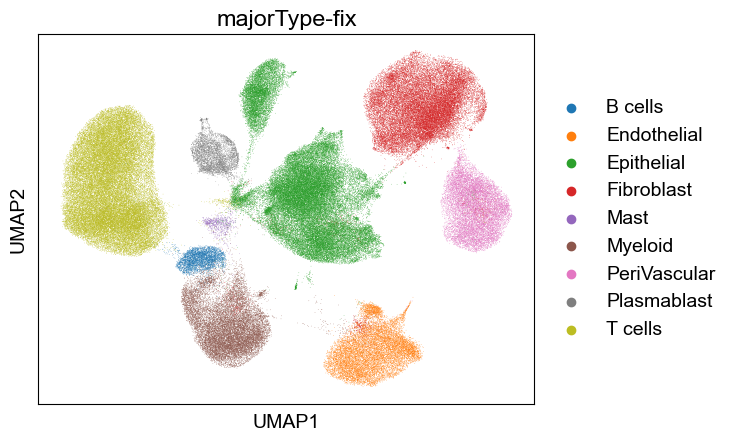

In [5]:
sc.pl.umap(adata_origin, color="majorType-fix")

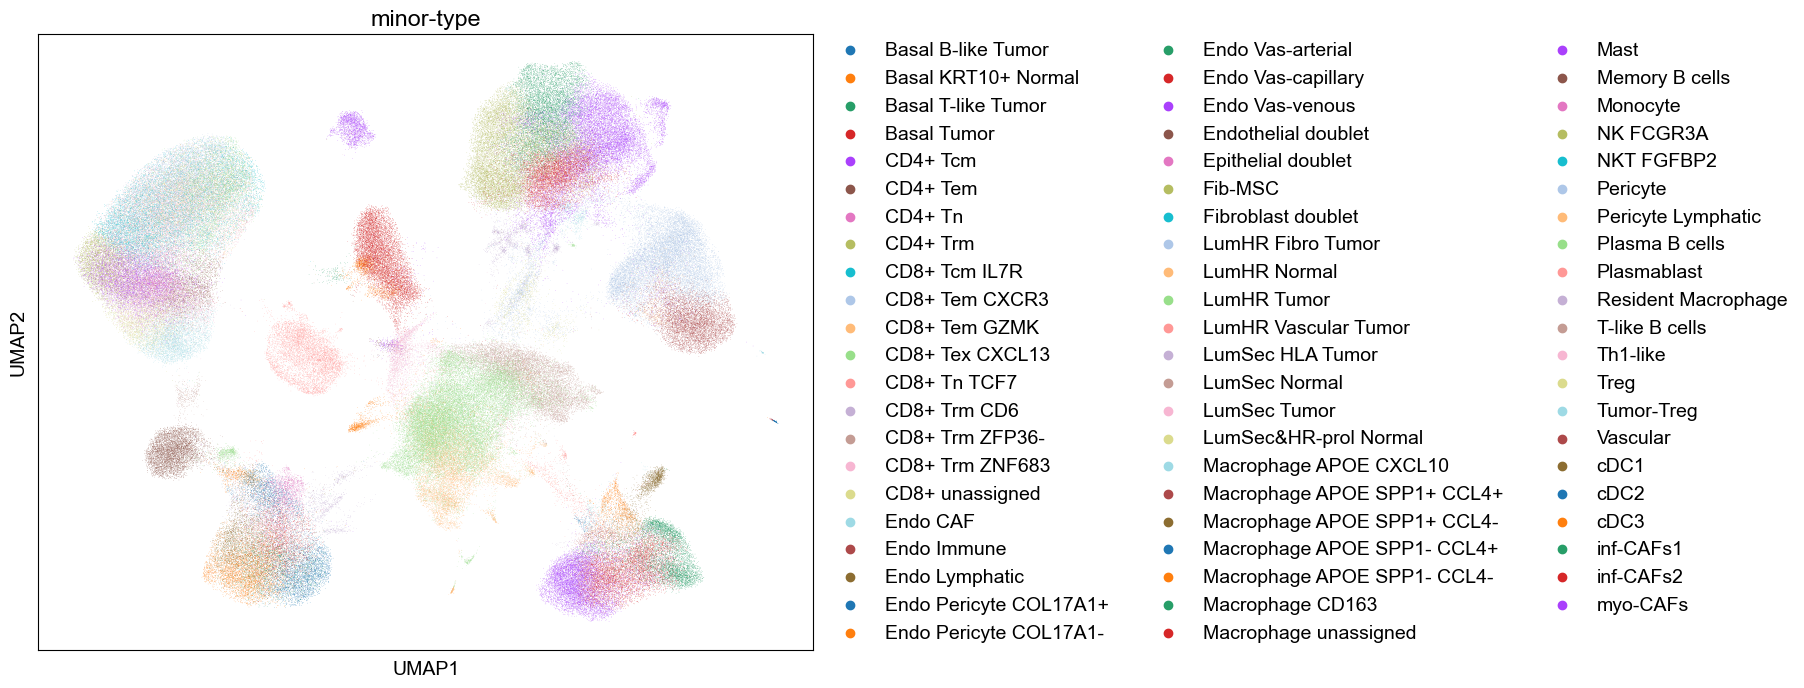

In [162]:
fig,ax = plt.subplots(figsize=(10,8))
sc.pl.umap(adata_origin, color="minor-type", ax=ax)
fig.savefig("figures/umap-minor-type.png", dpi=300, bbox_inches='tight')

In [164]:
len(np.unique(adata_origin.obs['minor-type']))

65

In [7]:
adata_origin.obs['batch'].cat.categories

Index(['1T', '2T', '3T', '5N', '5T', '6N', '6T', '8T', '9T', '10N', '10T',
       '12N', '15T', '16N', '17T', '20T', '21T', '22T'],
      dtype='object')

In [9]:
adata = adata_origin

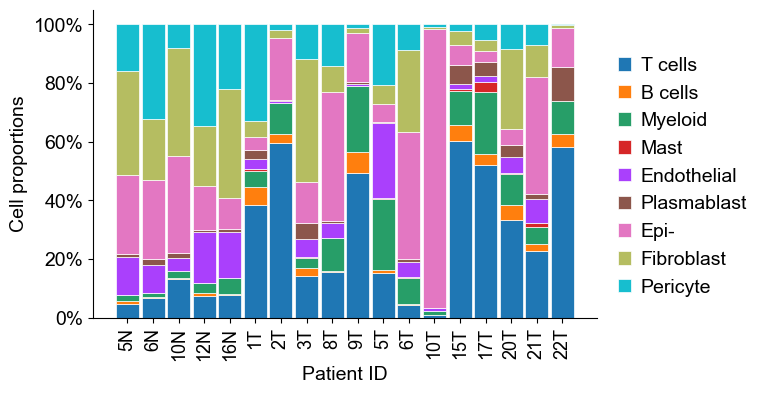

In [11]:
barlabels = ['5N', '6N', '10N', '12N','16N','1T', '2T', '3T', '8T', '9T', '5T','6T', '10T','15T','17T','20T', '21T', '22T']
cell_types = ['T cells', 'B cells', 'Myeloid', 'Mast', 'Endothelial','Plasmablast', 'Epi-', 'Fibroblast', 
       'Pericyte']
age_df = pd.DataFrame(columns = list(cell_types))
for bar in barlabels:
    d1 = pd.DataFrame([len(adata[(adata.obs["major_type_harmony"] == ct) & (adata.obs["batch"] == bar)]) for ct in list(cell_types)], index = list(cell_types), columns=[bar]).T
    age_df = pd.concat([age_df, d1])
fig0, ax0 = plt.subplots(figsize=(6.5, 4))
propPlot(age_df, ax0)
fig0.savefig("adata-major-proportions1.svg")

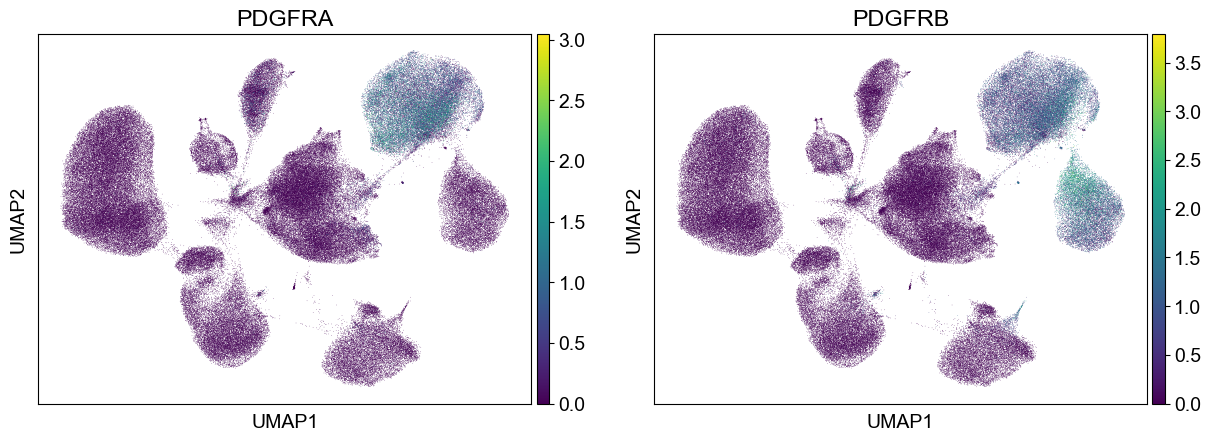

In [12]:
sc.pl.umap(adata, color=['PDGFRA', 'PDGFRB'])

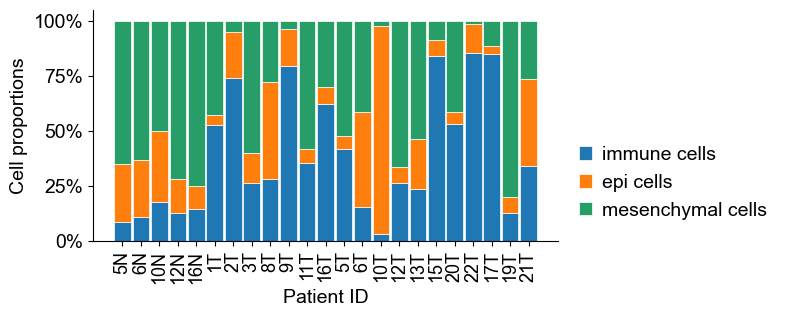

In [80]:
# print immune epi and mesenchyme cell proportions
barlabels = ['5N', '6N', '10N', '12N','16N','1T', '2T', '3T',  '8T', '9T','11T', '16T', '5T','6T', '10T',  '12T', '13T', '15T','20T',  '22T','17T',  '19T',  '21T']
general_types = {
    'immune cells': ['T cells', 'B cells', 'Myeloid', 'Mast', 'Plasmablast'],
    'epi cells':['Epi-'],
    'mesenchymal cells': ['Endothelial','Fibroblast', 'Pericyte']
}
age_df = pd.DataFrame(columns = list(general_types.keys()))
for bar in barlabels:
    d1 = pd.DataFrame([len(adata[(adata.obs["major_type_harmony"].isin(general_types[type])) & (adata.obs["batch"] == bar)]) 
                       for type in list(general_types.keys())], 
                      index =list(general_types.keys()), columns=[bar]).T
    age_df = pd.concat([age_df, d1])
fig1, ax1 = plt.subplots(figsize=(6, 3))
propPlot(age_df, ax1)
fig1.savefig("adata-general-proportion.svg")

In [10]:
def propPlot(age_df, ax, colors=sc.pl.palettes.default_20, xlabel='Patient ID', show_y=True, xrotate=90):
    all_df = age_df.sum(axis=1)
    age_normdf = pd.DataFrame([age_df.loc[i,:]/all_df[i] for i in barlabels], index=barlabels)
    age_cumdf = pd.DataFrame([np.cumsum(age_normdf.loc[i,:]) for i in barlabels], index=barlabels)
    norm_gdfs = age_normdf
    cum_gdfs = age_cumdf
    for i, col in enumerate(age_df.columns):
        height = norm_gdfs[col]
        starts = cum_gdfs[col] - height
        rects = ax.bar(barlabels, height, bottom=starts, width=0.9, color=colors[i], edgecolor='white', linewidth=0.5,
                        label=col, alpha=1)
    
        # ax.bar_label(rects,age_df.loc[:, col], label_type='center', color='lightgrey', fontsize=14)
    ax.legend( bbox_to_anchor=(1, 0), 
              handletextpad=0.5, frameon=False,
                          borderpad=0.6,
                          columnspacing=1.3,
                          handlelength=0.65,
              loc='lower left', fontsize=14)
    if show_y:
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
        ax.set_ylabel('Cell proportions')
    else:
        ax.yaxis.set_visible(False)
        ax.spines.left.set_visible(False)
    ax.set_xlabel(xlabel)
    ax.set_xticks(barlabels)
    ax.set_xticklabels(labels=barlabels,rotation=xrotate,fontsize=13)
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)

In [ ]:
fracNames = {'1T':'TNBC', 
             '2T':'TNBC', 
             '3T':'TNBC', 
             '4T-Male':'Luminal B', 
             '5N':'Normal', 
             '5T':'Luminal B', 
             '6N':'Normal', 
             '6T':'Luminal B', 
             '7N-Male':'Normal', 
             '8T':'TNBC', 
             '9T':'TNBC',
             '10T': 'Luminal B', 
             '10N': 'Normal',
             '11T': 'TNBC', 
             '12N': 'Normal', 
             '12T': 'Luminal B', 
             '13T': 'Luminal B', 
             '14T-Male': 'HER2+', 
             '15T': 'Luminal B', 
             '16N': 'Normal', 
             '16T': 'TNBC', 
             '17T':'HER2+', 
             '19T': 'HER2+', 
             '20T': 'Luminal B', 
             '21T': 'HER2+', 
             '22T': 'Luminal B'}

In [86]:
adata

AnnData object with n_obs × n_vars = 253234 × 41733
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'major_type', 'molecular_type', 'leiden_harmony', 'major_type_harmony'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'leiden_harmony_colors', 'log1p', 'major_type_colors', 'major_type_harmony_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [107]:
# 样本平均reads数
adata_concat = sc.read_h5ad("BCY-adata-clustered.h5ad")

In [103]:
adata.var["pct_dropout_by_counts"].mean()

95.33151846755175

In [106]:
adata_concat

AnnData object with n_obs × n_vars = 266942 × 61487
    obs: 'batch'

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


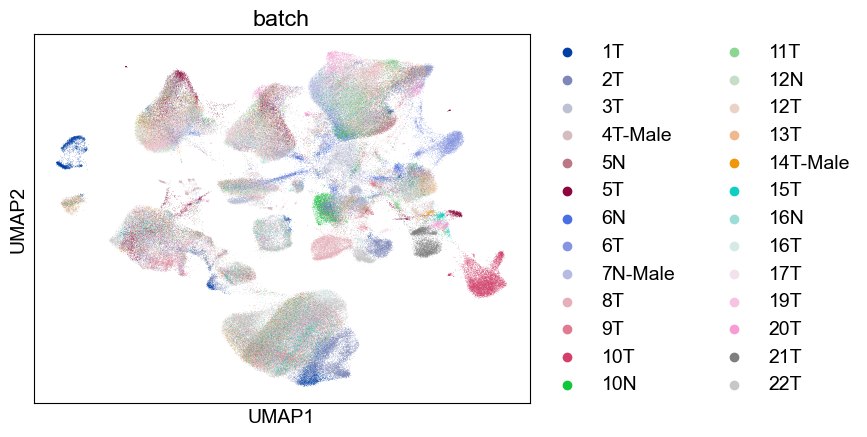

In [108]:
sc.pl.umap(adata_concat, color="batch", save="-batch.png")

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


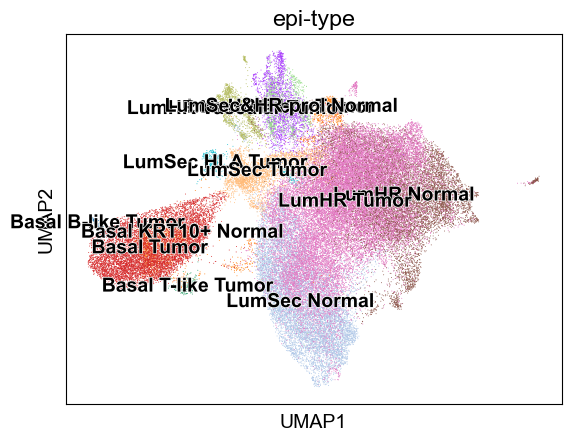

In [6]:
# the proportion of epithelial cells
adata_epi = sc.read_h5ad("adata-epi.h5ad")
adata_epi = adata_epi[~adata_epi.obs['epi-type'].isin(["Plasma B cells", 'Epithelial doublet'])]
sc.pl.umap(adata_epi, color="epi-type", legend_fontoutline=True, legend_loc="on data", palette=sc.pl.palettes.default_20, save="-epi.svg")

/tmp/ipykernel_1842867/491979891.py:36: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.savefig("adata-epi-NTprop.svg", bbox_inches='tight')


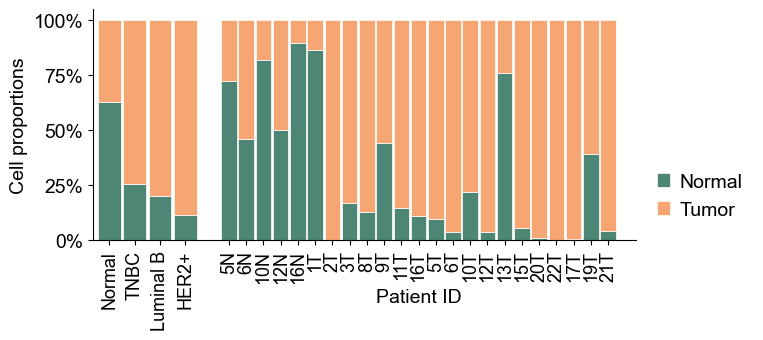

In [148]:
# print immune epi and mesenchyme cell proportions
import matplotlib.gridspec as gridspec
fig = plt.figure(tight_layout=True, figsize=(7,3))
gs = gridspec.GridSpec(1, 5, wspace=0)


barlabels = ['Normal', 'TNBC', 'Luminal B', 'HER2+']
general_types = {
    'Normal': ['Basal KRT10+ Normal', 'LumHR Normal', 'LumSec Normal', 'LumSec&HR-prol Normal'],
    'Tumor':['Basal B-like Tumor', 'Basal Tumor', 'Basal T-like Tumor', 'LumHR Fibro Tumor', 'LumHR Tumor', 'LumHR Vascular Tumor', 'LumSec HLA Tumor', 'LumSec Tumor'],
}
age_df = pd.DataFrame(columns = list(general_types.keys()))
for bar in barlabels:
    d1 = pd.DataFrame([len(adata_epi[(adata_epi.obs["epi-type"].isin(general_types[type])) & (adata_epi.obs["molecular_type"] == bar)]) 
                       for type in list(general_types.keys())], 
                      index =list(general_types.keys()), columns=[bar]).T
    age_df = pd.concat([age_df, d1])
ax1 = fig.add_subplot(gs[0, 0])
propPlot(age_df, ax1,colors=['#4d8675', '#f5a673'], xlabel='')



barlabels = ['5N', '6N', '10N', '12N','16N','1T', '2T', '3T',  '8T', '9T','11T', '16T', '5T','6T', '10T',  '12T', '13T', '15T','20T',  '22T','17T',  '19T',  '21T']
general_types = {
    'Normal': ['Basal KRT10+ Normal', 'LumHR Normal', 'LumSec Normal', 'LumSec&HR-prol Normal'],
    'Tumor':['Basal B-like Tumor', 'Basal Tumor', 'Basal T-like Tumor', 'LumHR Fibro Tumor', 'LumHR Tumor', 'LumHR Vascular Tumor', 'LumSec HLA Tumor', 'LumSec Tumor'],
}
age_df = pd.DataFrame(columns = list(general_types.keys()))
for bar in barlabels:
    d1 = pd.DataFrame([len(adata[(adata.obs["epi-type"].isin(general_types[type])) & (adata.obs["batch"] == bar)]) 
                       for type in list(general_types.keys())], 
                      index =list(general_types.keys()), columns=[bar]).T
    age_df = pd.concat([age_df, d1])
ax2 = fig.add_subplot(gs[0, 1:])
propPlot(age_df, ax2,colors=['#4d8675', '#f5a673'], show_y=False)
fig.savefig("adata-epi-NTprop.svg", bbox_inches='tight')

/tmp/ipykernel_1842867/3660015835.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.savefig("adata-epi-BLprop4.svg", bbox_inches='tight')


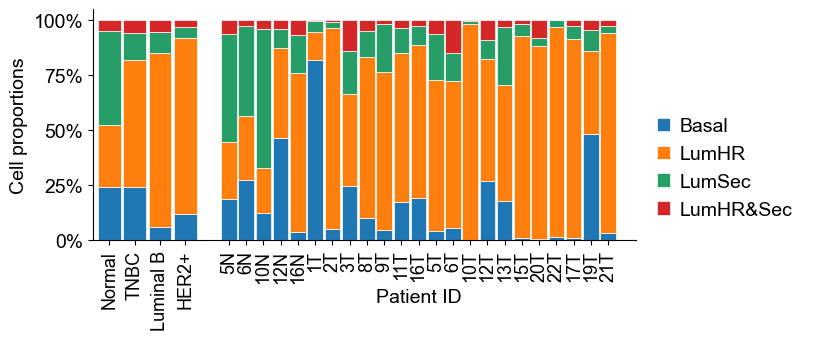

In [143]:
# print immune epi and mesenchyme cell proportions
import matplotlib.gridspec as gridspec
fig = plt.figure(tight_layout=True, figsize=(8,3))
gs = gridspec.GridSpec(1, 5, wspace=0)
barlabels = ['Normal', 'TNBC', 'Luminal B', 'HER2+']
general_types = {
    'Basal': ['Basal KRT10+ Normal', 'Basal B-like Tumor', 'Basal Tumor', 'Basal T-like Tumor'],
    'LumHR':['LumHR Tumor', 'LumHR Vascular Tumor','LumHR Normal', ],
    'LumSec': ['LumSec HLA Tumor', 'LumSec Tumor', 'LumSec Normal', ],
    'LumHR&Sec': ['LumSec&HR-prol Normal', 'LumHR Fibro Tumor',]
}
age_df = pd.DataFrame(columns = list(general_types.keys()))
for bar in barlabels:
    d1 = pd.DataFrame([len(adata_epi[(adata.obs["epi-type"].isin(general_types[type])) & (adata_epi.obs["molecular_type"] == bar)]) 
                       for type in list(general_types.keys())], 
                      index =list(general_types.keys()), columns=[bar]).T
    age_df = pd.concat([age_df, d1])
ax1 = fig.add_subplot(gs[0, 0])
propPlot(age_df, ax1, xlabel='', xrotate=90)
# print immune epi and mesenchyme cell proportions
barlabels = ['5N', '6N', '10N', '12N','16N','1T', '2T', '3T',  '8T', '9T','11T', '16T', '5T','6T', '10T',  '12T', '13T', '15T','20T',  '22T','17T',  '19T',  '21T']
general_types = {
    'Basal': ['Basal KRT10+ Normal', 'Basal B-like Tumor', 'Basal Tumor', 'Basal T-like Tumor'],
    'LumHR':['LumHR Tumor', 'LumHR Vascular Tumor','LumHR Normal', ],
    'LumSec': ['LumSec HLA Tumor', 'LumSec Tumor', 'LumSec Normal', ],
    'LumHR&Sec': ['LumSec&HR-prol Normal', 'LumHR Fibro Tumor',]
}
age_df = pd.DataFrame(columns = list(general_types.keys()))
for bar in barlabels:
    d1 = pd.DataFrame([len(adata_epi[(adata_epi.obs["epi-type"].isin(general_types[type])) & (adata_epi.obs["batch"] == bar)]) 
                       for type in list(general_types.keys())], 
                      index =list(general_types.keys()), columns=[bar]).T
    age_df = pd.concat([age_df, d1])
ax2 = fig.add_subplot(gs[0, 1:])
propPlot(age_df, ax2, xlabel='Patient ID', show_y=False)
fig.savefig("adata-epi-BLprop4.svg", bbox_inches='tight')

In [128]:
import matplotlib.gridspec as gridspec
?gridspec.GridSpec

Init signature:
gridspec.GridSpec(
    nrows,
    ncols,
    figure=None,
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=None,
    hspace=None,
    width_ratios=None,
    height_ratios=None,
)
Docstring:     
A grid layout to place subplots within a figure.

The location of the grid cells is determined in a similar way to
`~.figure.SubplotParams` using *left*, *right*, *top*, *bottom*, *wspace*
and *hspace*.

Indexing a GridSpec instance returns a `.SubplotSpec`.
Init docstring:
Parameters
----------
nrows, ncols : int
    The number of rows and columns of the grid.

figure : `.Figure`, optional
    Only used for constrained layout to create a proper layoutgrid.

left, right, top, bottom : float, optional
    Extent of the subplots as a fraction of figure width or height.
    Left cannot be larger than right, and bottom cannot be larger than
    top. If not given, the values will be inferred from a figure or
    rcParams at draw time. See also `GridSpec.get_su

In [65]:
adata_epi.obs['epi-BLtype'] = list(adata_epi.obs['epi-type'])
for key in general_types:
    adata_epi.obs.loc[adata_epi.obs['epi-type'].isin(general_types[key]), 'epi-BLtype'] = key
adata_epi.obs['epi-BLtype']

barcodes
AAACCCAAGACCAAGC-1-1T     Basal
AAACCCATCACTTTGT-1-1T     Basal
AAACGAAAGCGGATCA-1-1T     LumHR
AAACGAACACAGTGTT-1-1T     Basal
AAACGCTCAAGCAATA-1-1T     LumHR
                          ...  
TTTGGTTGTCCCTACT-1-22T    LumHR
TTTGGTTGTGATGATA-1-22T    LumHR
TTTGTCAAGGCAAAGA-1-22T    LumHR
TTTGTCAGTCATCCCT-1-22T    LumHR
TTTGTCATCAATCACG-1-22T    LumHR
Name: epi-BLtype, Length: 65518, dtype: object

In [69]:
# show KRT families
KRT_genes = adata_epi.var_names.str.startswith('KRT')
list(adata_epi.var_names[KRT_genes])

['KRT18P12',
 'KRT18P28',
 'KRTCAP2',
 'KRT8P29',
 'KRT8P47',
 'KRT18P57',
 'KRT8P28',
 'KRT8P45',
 'KRTCAP2P1',
 'KRT18P33',
 'KRT18P39',
 'KRT8P10',
 'KRT18P19',
 'KRT18P52',
 'KRTCAP3',
 'KRT18P26',
 'KRT8P15',
 'KRT8P52',
 'KRT18P15',
 'KRT8P36',
 'KRT18P34',
 'KRT18P35',
 'KRT8P13',
 'KRT8P12',
 'KRT18P17',
 'KRT18P63',
 'KRT8P46',
 'KRT8P31',
 'KRT8P32',
 'KRT18P16',
 'KRT8P33',
 'KRT8P48',
 'KRT18P31',
 'KRT18P1',
 'KRT18P38',
 'KRT18P9',
 'KRT19P1',
 'KRT8P42',
 'KRT8P44',
 'KRT18P65',
 'KRT18P11',
 'KRT18P68',
 'KRT8P8',
 'KRT18P48',
 'KRT18P49',
 'KRT8P3',
 'KRT8P4',
 'KRT18P37',
 'KRT18P13',
 'KRT8P11',
 'KRT18P67',
 'KRT18P59',
 'KRT8P49',
 'KRT18P58',
 'KRTAP5-AS1',
 'KRTAP5-1',
 'KRTAP5-2',
 'KRTAP5-6',
 'KRT8P26',
 'KRT8P41',
 'KRTAP5-7',
 'KRTAP5-8',
 'KRTAP5-9',
 'KRTAP5-10',
 'KRTAP5-4',
 'KRTAP5-11',
 'KRT74',
 'KRT87P',
 'KRT6B',
 'KRT8P39',
 'KRT86',
 'KRT85',
 'KRT89P',
 'KRT6C',
 'KRT2',
 'KRT5',
 'KRT84',
 'KRT75',
 'KRT1',
 'KRT72',
 'KRT83',
 'KRT73',
 'KRT6A'

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


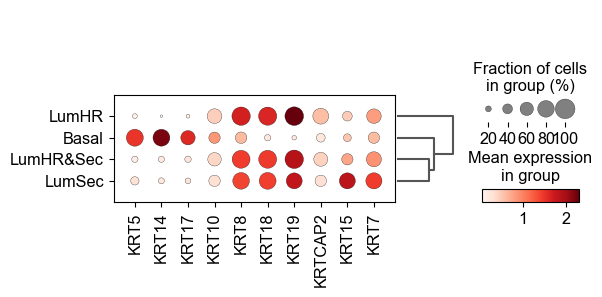

In [109]:
sc.pl.rank_genes_groups_dotplot(adata_epi, groupby="epi-BLtype", var_names=['KRT5','KRT14',  'KRT17', 'KRT10','KRT8',
                                                                            'KRT18', 'KRT19', 'KRTCAP2','KRT15','KRT7',
                                                                         ], save='epi-KRT.svg')

In [97]:
sc.tl.score_genes_cell_cycle(adata_epi, s_genes=["MCM5",     "PCNA",     "TYMS",     "FEN1",     "MCM7",     "MCM4",    
"RRM1",     "UNG",      "GINS2",    "MCM6",     "CDCA7",    "DTL",     
"PRIM1",    "UHRF1",    "CENPU",    "HELLS",    "RFC2",     "POLR1B",  
"NASP",     "RAD51AP1", "GMNN",     "WDR76",    "SLBP",     "CCNE2",   
"UBR7",     "POLD3",    "MSH2",     "ATAD2",    "RAD51",    "RRM2",    
"CDC45",    "CDC6",     "EXO1",     "TIPIN",    "DSCC1",    "BLM",     
"CASP8AP2", "USP1",     "CLSPN",    "POLA1",    "CHAF1B",   "MRPL36",  
"E2F8"], g2m_genes=["HMGB2",   "CDK1",    "NUSAP1",  "UBE2C",   "BIRC5",   "TPX2",    "TOP2A",  
"NDC80",   "CKS2",    "NUF2",    "CKS1B",   "MKI67",   "TMPO",    "CENPF",  
"TACC3",   "PIMREG",  "SMC4",    "CCNB2",   "CKAP2L",  "CKAP2",   "AURKB",  
"BUB1",    "KIF11",   "ANP32E",  "TUBB4B",  "GTSE1",   "KIF20B",  "HJURP",  
"CDCA3",   "JPT1",    "CDC20",   "TTK",     "CDC25C",  "KIF2C",   "RANGAP1",
"NCAPD2",  "DLGAP5",  "CDCA2",   "CDCA8",   "ECT2",    "KIF23",   "HMMR",   
"AURKA",   "PSRC1",   "ANLN",    "LBR",     "CKAP5",   "CENPE",   "CTCF",   
"NEK2",    "G2E3",    "GAS2L3",  "CBX5",    "CENPA",])

In [100]:
adata_epi

AnnData object with n_obs × n_vars = 65518 × 41733
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'major_type', 'molecular_type', 'leiden_harmony', 'major_type_harmony', 'minor_type', 'minor-type', 'doublet_score', 'predicted_doublet', 'leiden-epi-harmony', 'cnv_status', 'epi-type', 'epi-BLtype', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cnv_status_colors', 'dendrogram_leiden', 'epi-type_colors', 'hvg', 'leiden', 'leiden-epi-harmony_colors', 'leiden_colors', 'leiden_harmony_colors', 'log1p', 'major_type_colors', 'major_type_harmony_colors', 'minor-type_colors', 'molecular_type_colors', 'neighbors', 'pca', 'rank_genes_groups', 'scrublet', 'umap', 'dendrogram_epi-type', 'den

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


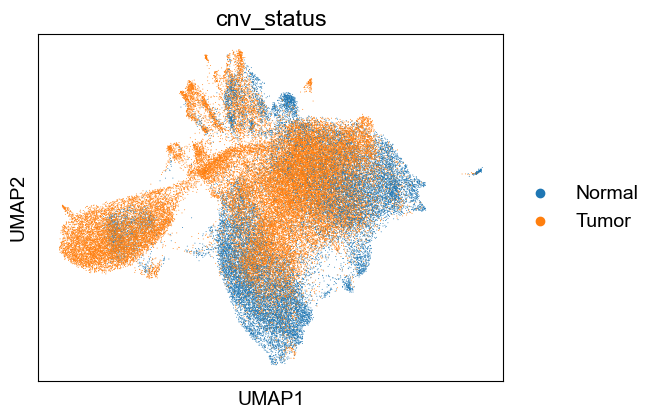

In [117]:
fig0, ax0 = plt.subplots(figsize=(6, 4.5))
sc.pl.umap(adata_epi, color="cnv_status", ax=ax0)
fig0.savefig("figures/umap-epi-cnv.png", dpi=300, bbox_inches='tight')

In [30]:
def marker(adata, groupby, method='wilcoxon'):
    sc.tl.rank_genes_groups(adata, groupby = groupby, method = method)
    sc.tl.dendrogram(adata, groupby=groupby, use_rep='X_pca_harmony')
    sc.pl.rank_genes_groups_dotplot(adata, groupby = groupby)
    return adata

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


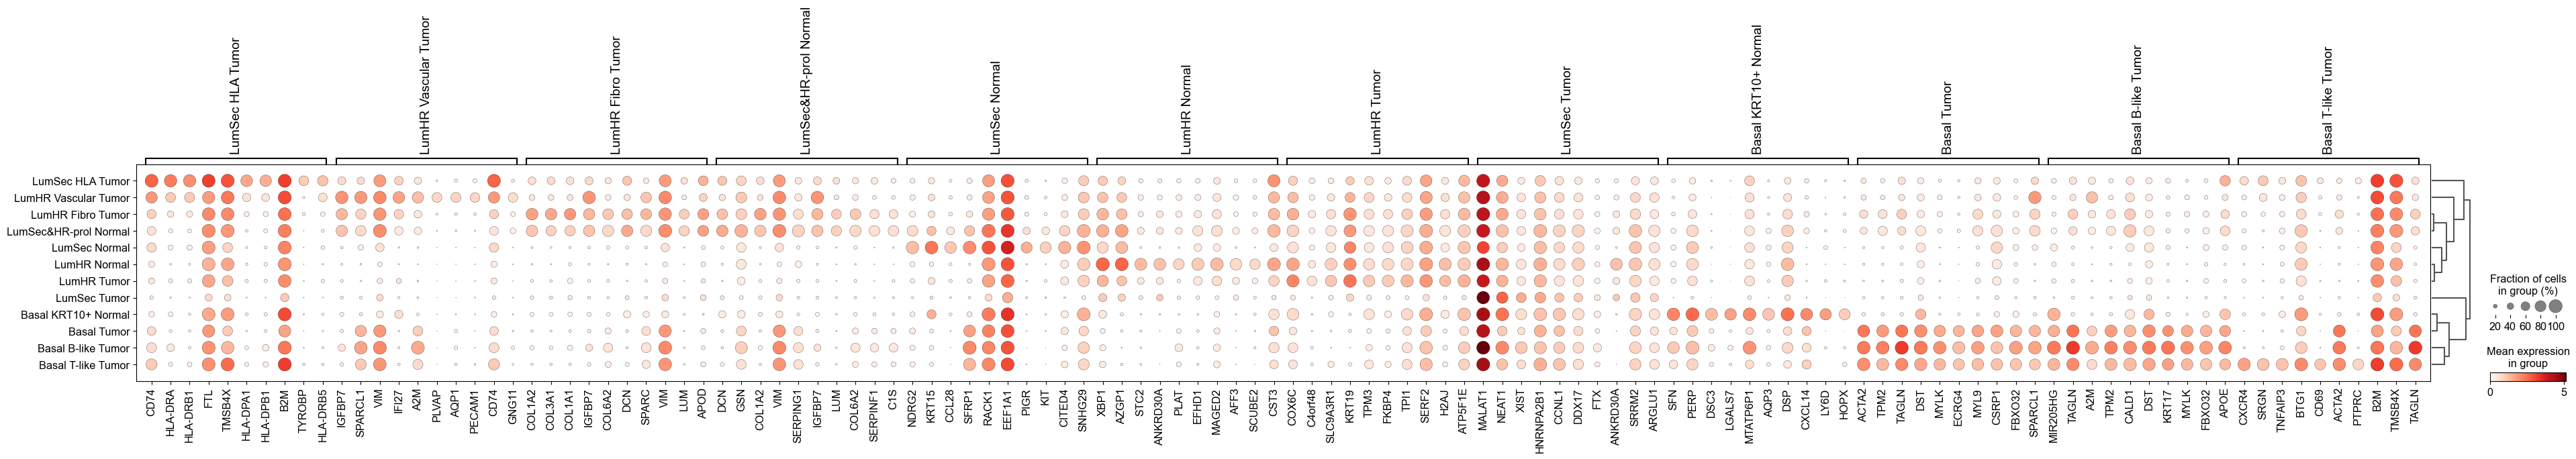

In [74]:
adata_epi=marker(adata_epi, groupby="epi-type")

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


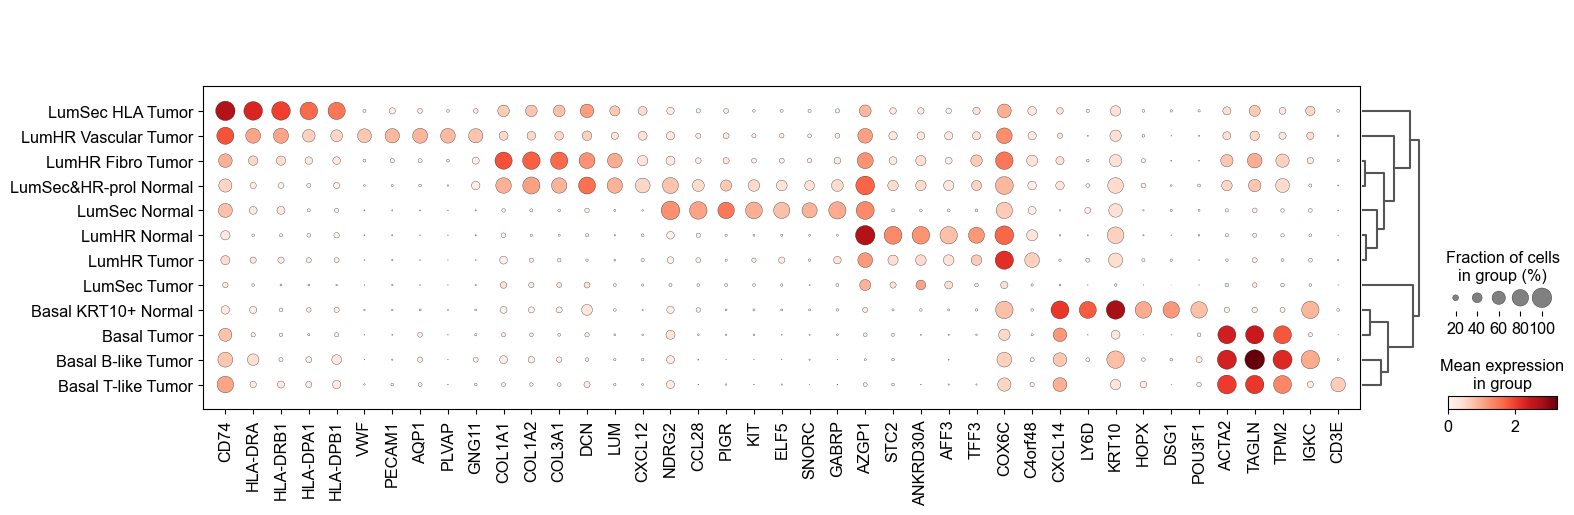

In [110]:
sc.pl.rank_genes_groups_dotplot(adata_epi, groupby="epi-type", var_names=['CD74', 'HLA-DRA', 'HLA-DRB1', 'HLA-DPA1', 'HLA-DPB1',
                                                                         'VWF','PECAM1', 'AQP1', 'PLVAP', 'GNG11', 
                                                                         'COL1A1', 'COL1A2', 'COL3A1', 'DCN', 'LUM', 'CXCL12',
                                                                         'NDRG2', 'CCL28', 'PIGR', 'KIT', 'ELF5', 'SNORC', 'GABRP',
                                                                         'AZGP1', 'STC2', 'ANKRD30A', 'AFF3', 'TFF3', 'COX6C', 'C4orf48',
                                                                         'CXCL14', 'LY6D', 'KRT10', 'HOPX', 'DSG1', 'POU3F1',
                                                                          'ACTA2', 'TAGLN', 'TPM2', 'IGKC', 'CD3E'
                                                                         ], save='epi-main.svg')

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


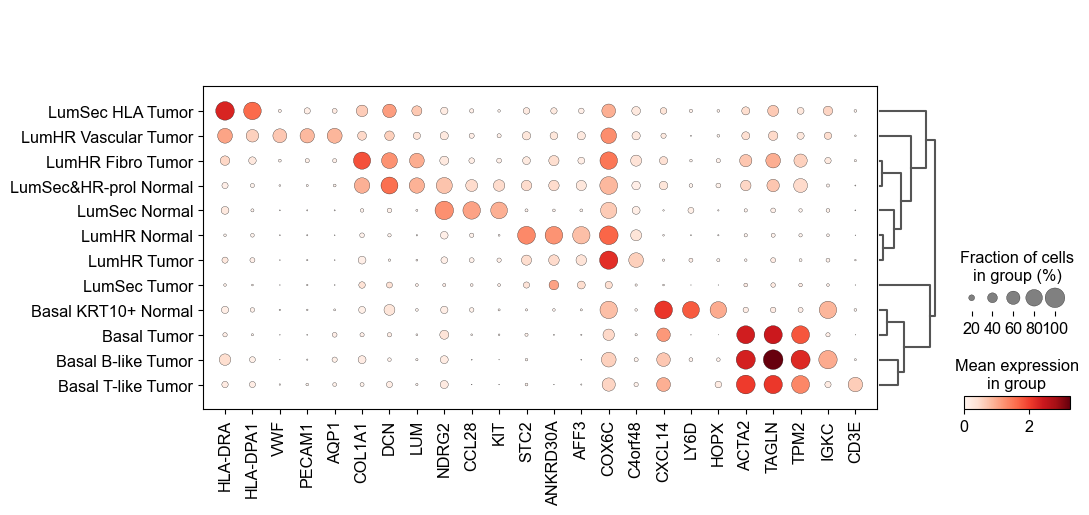

In [112]:
sc.pl.rank_genes_groups_dotplot(adata_epi, groupby="epi-type", var_names=['HLA-DRA', 'HLA-DPA1', 
                                                                         'VWF','PECAM1', 'AQP1',  
                                                                         'COL1A1', 'DCN', 'LUM',
                                                                         'NDRG2', 'CCL28', 'KIT',
                                                                         'STC2', 'ANKRD30A', 'AFF3', 'COX6C', 'C4orf48',
                                                                         'CXCL14', 'LY6D', 'HOPX',
                                                                          'ACTA2', 'TAGLN', 'TPM2', 'IGKC', 'CD3E'
                                                                         ], save='epi-small.svg')

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


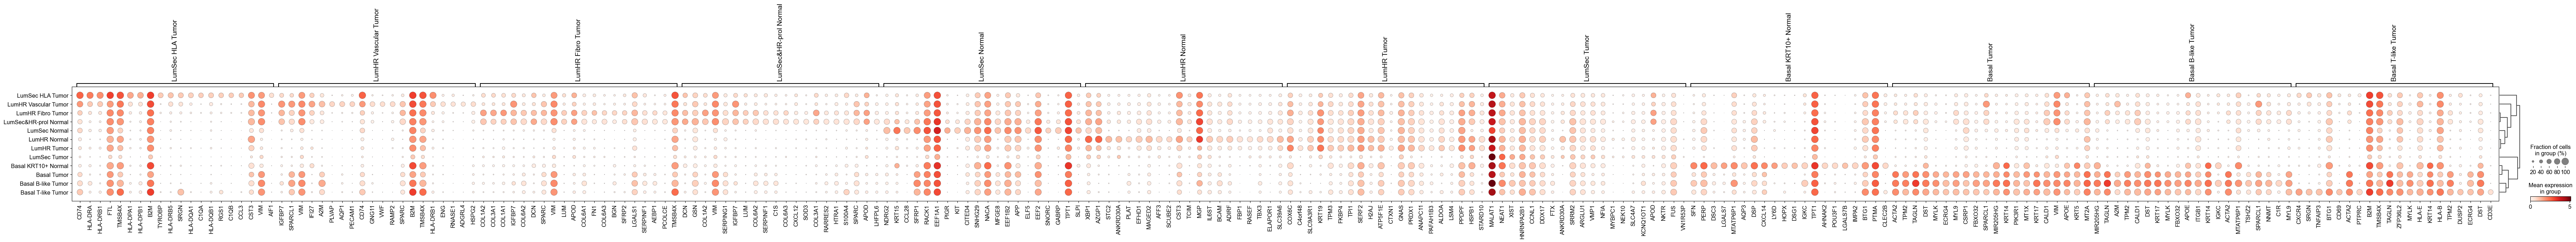

In [50]:
sc.pl.rank_genes_groups_dotplot(adata_epi, groupby = 'epi-type', n_genes=20)

In [149]:
import scvelo as scv

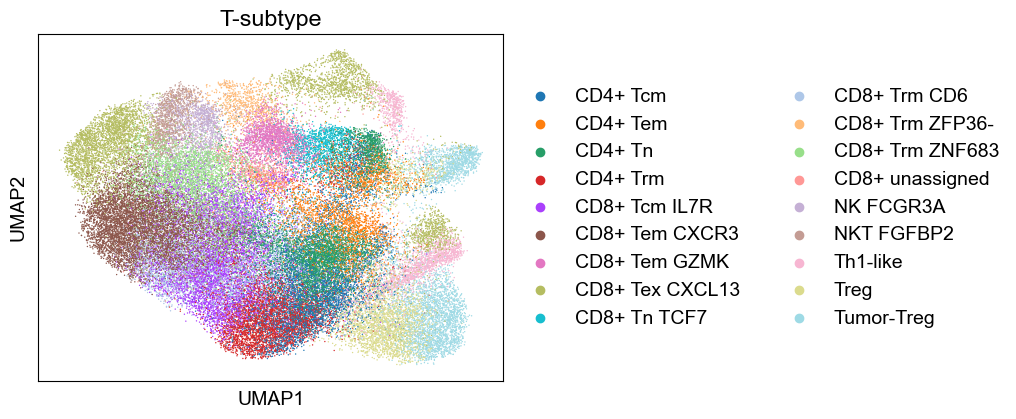

In [207]:
adata_T = sc.read_h5ad("adata-T.h5ad")
fig,ax = plt.subplots()
sc.pl.umap(adata_T, color="T-subtype", ax=ax, size=4)
fig.savefig("figures/umap-T-type.png", dpi=300, bbox_inches='tight')

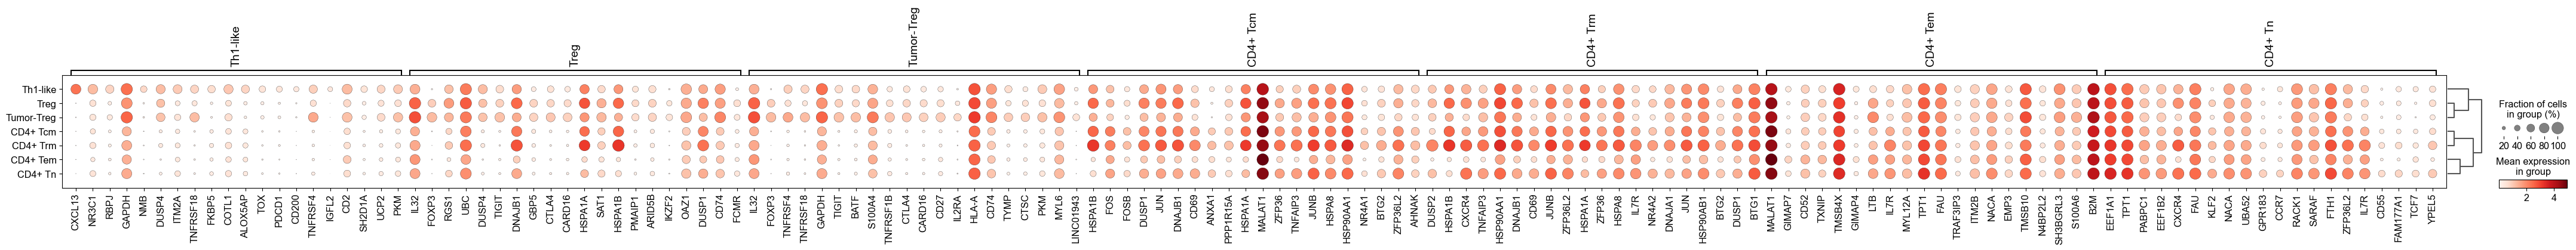

In [170]:
adata_CD4T = sc.read_h5ad("adata-CD4T.h5ad")
sc.pl.rank_genes_groups_dotplot(adata_CD4T, groupby="T-CD4-type", n_genes=20)

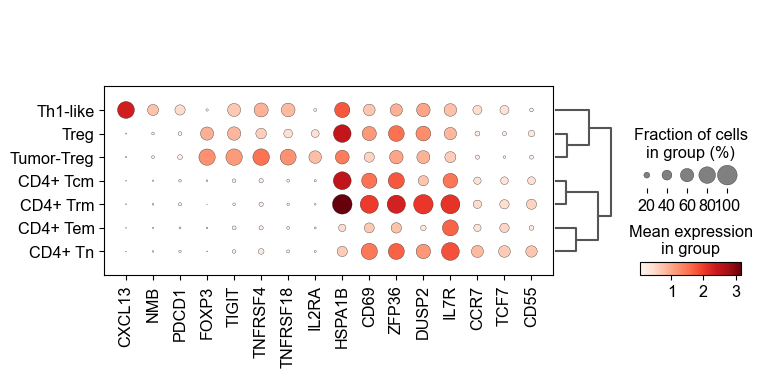

In [193]:
sc.pl.rank_genes_groups_dotplot(adata_CD4T, groupby="T-CD4-type", var_names=['CXCL13','NMB',  'PDCD1', 
                                                                         'FOXP3','TIGIT', 'TNFRSF4',  'TNFRSF18','IL2RA',
                                                                         'HSPA1B','CD69', 'ZFP36', "DUSP2",'IL7R', 'CCR7', 'TCF7','CD55',
                                                                         ], save='CD4T-small.svg')

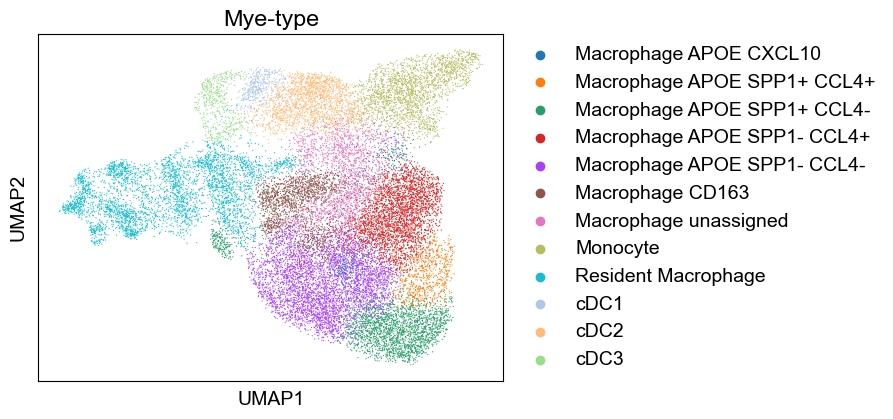

In [197]:
adata_Mye = sc.read_h5ad("adata-Mye.h5ad")
fig,ax = plt.subplots(figsize=(6,4.5))
sc.pl.umap(adata_Mye, color="Mye-type", ax=ax, size=3)
fig.savefig("figures/umap-Mye-type.png", dpi=300, bbox_inches='tight')

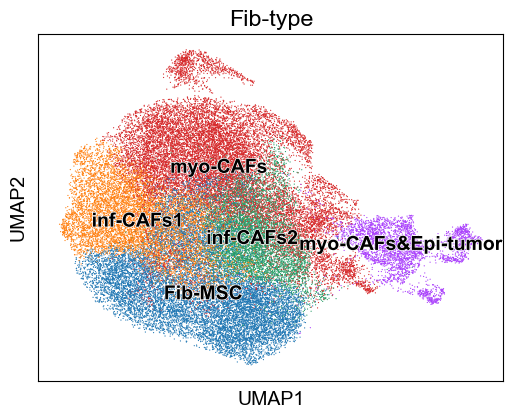

In [199]:
adata_Fib = sc.read_h5ad("adata-Fib.h5ad")
fig,ax = plt.subplots(figsize=(6,4.5))
sc.pl.umap(adata_Fib, color="Fib-type", ax=ax, size=3, legend_loc='on data', legend_fontoutline=True)
fig.savefig("figures/umap-Fib-type.png", dpi=300, bbox_inches='tight')

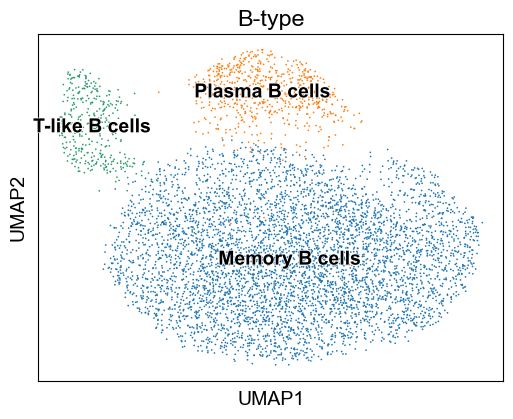

In [202]:
adata_B = sc.read_h5ad("adata-B.h5ad")
fig,ax = plt.subplots(figsize=(6,4.5))
sc.pl.umap(adata_B, color="B-type", ax=ax, size=6, legend_loc='on data', legend_fontoutline=True)
fig.savefig("figures/umap-B-type.png", dpi=300, bbox_inches='tight')

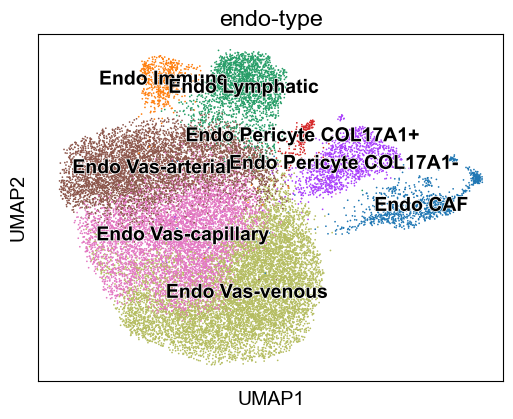

In [208]:
adata_endo = sc.read_h5ad("adata-endo.h5ad")
fig,ax = plt.subplots(figsize=(6,4.5))
sc.pl.umap(adata_endo, color="endo-type", ax=ax, size=6, legend_loc='on data', legend_fontoutline=True)
fig.savefig("figures/umap-endo-type.png", dpi=300, bbox_inches='tight')

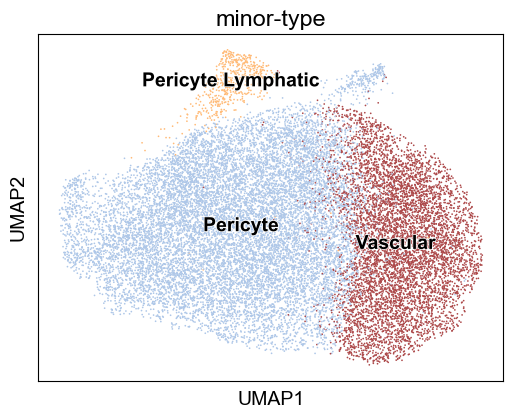

In [206]:
adata_pvl = sc.read_h5ad("adata-pvl.h5ad")
fig,ax = plt.subplots(figsize=(6,4.5))
sc.pl.umap(adata_pvl, color="minor-type", ax=ax, size=6, legend_loc='on data', legend_fontoutline=True)
fig.savefig("figures/umap-pvl-type.png", dpi=300, bbox_inches='tight')